<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/image-classification/face-emotion.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/image-classification/face-emotion.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Face Emotion Classification



## 1. Setup

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

print(f"System version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")

System version: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
Tensorflow version: 2.8.0


## 2. Dataset

[Facial Expression Recognition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) data consists of 48x48 pixel grayscale images of faces. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

In this tutorial, we adapt the original dataset to form a binary classification task which is categorizing each face in to one of two categories (0=Sad, 1=Happy).

In [2]:
# Download data
# !curl -L 'https://static.preferred.ai/tutorial/face-emotion/data.zip' -o data.zip
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1mEfcmzGS92nFkfP27-gzaP1T84I8HjZJ" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1mEfcmzGS92nFkfP27-gzaP1T84I8HjZJ" -o data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:22 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:22 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:22 --:--:--     0
100  9.8M  100  9.8M    0     0   421k      0  0:00:23  0:00:23 --:--:-- 29.9M


In [3]:
!unzip -q data.zip

In [4]:
!ls data/images/

0  1


### Prepare the data

Let's use 90% of the data for model training and 10% for model validation.

In [5]:
val_size = 0.1  # @param
batch_size = 32  # @param
img_height = 48  # @param
img_width = 48  # @param

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/images",
  validation_split=val_size,
  subset="training",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/images",
  validation_split=val_size,
  subset="validation",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

# optimize data loading for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 9660 files belonging to 2 classes.
Using 8694 files for training.
Found 9660 files belonging to 2 classes.
Using 966 files for validation.


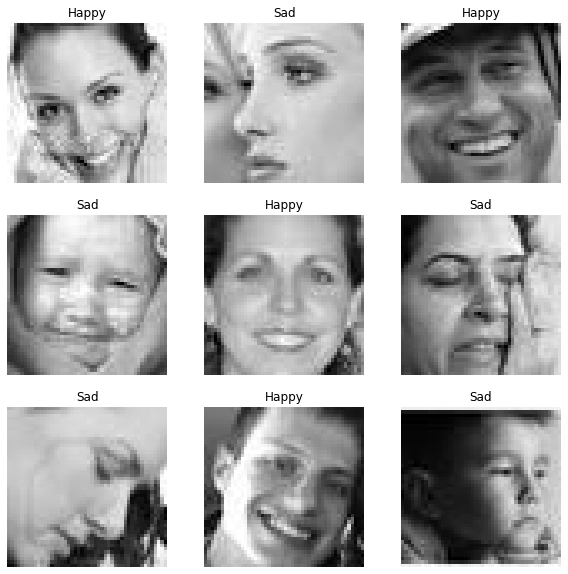

In [6]:
class_names = ['Sad', "Happy"]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8").reshape(48, 48), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 3. Multilayer Perceptron (MLP)


In [7]:
hidden_units = 128  # @param
dropout_rate = 0.2  # @param
learning_rate = 0.01  # @param

mlp_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),                        
  layers.Flatten(),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dropout(rate=dropout_rate),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dense(2)
], name="MLP")

mlp_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate,  momentum=0.9),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

mlp_model.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 48, 48, 1)         0         
                                                                 
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               295040    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 2)                 258     

In [8]:
mlp_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
);

Epoch 1/20
272/272 [==============================] - 8s 18ms/step - loss: 0.6399 - accuracy: 0.6504 - val_loss: 0.5708 - val_accuracy: 0.7267
Epoch 2/20
272/272 [==============================] - 1s 5ms/step - loss: 0.5803 - accuracy: 0.6923 - val_loss: 0.5442 - val_accuracy: 0.7350
Epoch 3/20
272/272 [==============================] - 1s 5ms/step - loss: 0.5576 - accuracy: 0.7180 - val_loss: 0.5346 - val_accuracy: 0.7422
Epoch 4/20
272/272 [==============================] - 1s 5ms/step - loss: 0.5404 - accuracy: 0.7266 - val_loss: 0.5381 - val_accuracy: 0.7319
Epoch 5/20
272/272 [==============================] - 1s 5ms/step - loss: 0.5259 - accuracy: 0.7373 - val_loss: 0.5307 - val_accuracy: 0.7350
Epoch 6/20
272/272 [==============================] - 1s 5ms/step - loss: 0.5119 - accuracy: 0.7441 - val_loss: 0.5138 - val_accuracy: 0.7402
Epoch 7/20
272/272 [==============================] - 3s 10ms/step - loss: 0.4986 - accuracy: 0.7544 - val_loss: 0.5052 - val_accuracy: 0.7464
Epoc

## 4. Shallow CNN



In [9]:
filters = 32  # @param
kernel_size = [3, 3]  # @param
strides = 1 # @param
hidden_units = 128  # @param
dropout_rate = 0.2  # @param
learning_rate = 0.01 # @param

shallow_cnn_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),  
  layers.Conv2D(filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Flatten(),
  layers.Dropout(rate=dropout_rate),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dense(2)
], name="Shallow-CNN")

shallow_cnn_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate, momentum=0.9),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

shallow_cnn_model.summary()

Model: "Shallow-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 48, 48, 1)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_1 (Dropout)         (None, 18432)             0         
                                                       

In [10]:
shallow_cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
272/272 [==============================] - 10s 9ms/step - loss: 0.6138 - accuracy: 0.6646 - val_loss: 0.5357 - val_accuracy: 0.7402
Epoch 2/20
272/272 [==============================] - 2s 9ms/step - loss: 0.5391 - accuracy: 0.7254 - val_loss: 0.5083 - val_accuracy: 0.7650
Epoch 3/20
272/272 [==============================] - 2s 8ms/step - loss: 0.4997 - accuracy: 0.7528 - val_loss: 0.4931 - val_accuracy: 0.7681
Epoch 4/20
272/272 [==============================] - 2s 8ms/step - loss: 0.4632 - accuracy: 0.7772 - val_loss: 0.4689 - val_accuracy: 0.7857
Epoch 5/20
272/272 [==============================] - 2s 8ms/step - loss: 0.4319 - accuracy: 0.7928 - val_loss: 0.4680 - val_accuracy: 0.7899
Epoch 6/20
272/272 [==============================] - 2s 9ms/step - loss: 0.3958 - accuracy: 0.8125 - val_loss: 0.4717 - val_accuracy: 0.7981
Epoch 7/20
272/272 [==============================] - 2s 9ms/step - loss: 0.3785 - accuracy: 0.8307 - val_loss: 0.4589 - val_accuracy: 0.7940
Epoch

## 5. Deep CNN

In [11]:
filters = 32  # @param
kernel_size = [3, 3]  # @param
strides = 1 # @param
hidden_units = 128  # @param
dropout_rate = 0.2  # @param
learning_rate = 0.01 # @param

deep_cnn_model = tf.keras.Sequential([
  tf.keras.Input(shape=(img_height, img_width, 1)),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),
  layers.Conv2D(filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Conv2D(2 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Conv2D(4 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.Conv2D(4 * filters, kernel_size, strides, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=[2, 2], strides=2),
  layers.Flatten(),
  layers.Dropout(rate=dropout_rate),
  layers.Dense(hidden_units, activation='relu'),
  layers.Dense(2)
], name="Deep-CNN")

deep_cnn_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate,  momentum=0.9),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

deep_cnn_model.summary()

Model: "Deep-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 48, 48, 1)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                      

In [12]:
history = deep_cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
272/272 [==============================] - 6s 17ms/step - loss: 0.6567 - accuracy: 0.6079 - val_loss: 0.5658 - val_accuracy: 0.7205
Epoch 2/20
272/272 [==============================] - 4s 15ms/step - loss: 0.5497 - accuracy: 0.7172 - val_loss: 0.4916 - val_accuracy: 0.7764
Epoch 3/20
272/272 [==============================] - 4s 16ms/step - loss: 0.4679 - accuracy: 0.7735 - val_loss: 0.4414 - val_accuracy: 0.7888
Epoch 4/20
272/272 [==============================] - 4s 15ms/step - loss: 0.4155 - accuracy: 0.7995 - val_loss: 0.4424 - val_accuracy: 0.7930
Epoch 5/20
272/272 [==============================] - 4s 15ms/step - loss: 0.3778 - accuracy: 0.8264 - val_loss: 0.3958 - val_accuracy: 0.8157
Epoch 6/20
272/272 [==============================] - 4s 15ms/step - loss: 0.3457 - accuracy: 0.8451 - val_loss: 0.3762 - val_accuracy: 0.8354
Epoch 7/20
272/272 [==============================] - 4s 15ms/step - loss: 0.3196 - accuracy: 0.8576 - val_loss: 0.3784 - val_accuracy: 0.8313

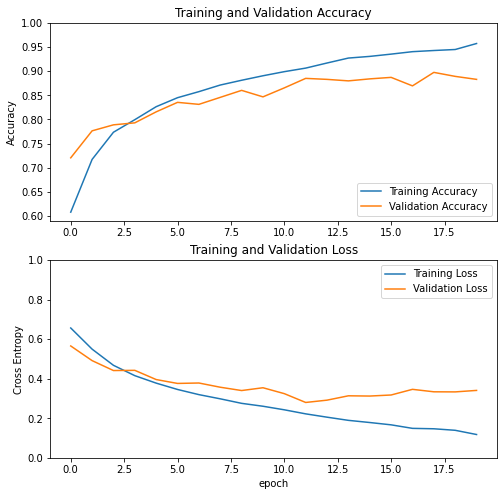

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 6. Visualization of Learned CNN Filters

Here we visualize the Deep CNN model with saliency map of images using [Guided Backpropagation](https://arxiv.org/abs/1412.6806) technique, and the activation maps of the 4th convolutional layer of the network.

We may notice that the model focuses more on the mouth with Happy emotion, while other parts of the face are paid attention with Sad emotion.

| Input Image                                                                                                                      | Saliency Map                                                                                                                                  | Activation Maps of the 4th Convolutional Layer                                                                                       | Label |
| :------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :------------------------------------------------------------------------------------------------------------------------------------: | :---: |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/82.jpg)  | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_82.jpg)  | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_82.jpg)  | Happy |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/130.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_130.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_130.jpg) | Sad   |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/791.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_791.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_791.jpg) | Happy |
| ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/607.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/saliency_map_607.jpg) | ![](https://raw.githubusercontent.com/PreferredAI/tutorials/master/image-classification/face-emotion/visualization/conv4_607.jpg) | Sad   |

Please refer to this [code](https://github.com/PreferredAI/tutorials/blob/7ccc67cde2408c873a6cba66b58ec56dee236a17/image-classification/face-emotion/src/visualize.py) for more details.